# Workshop on *Person verification in surveillance using feature extraction and learning*

Course: NICF- Vision Systems (SF)

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/vision-systems/analytics-and-intelligent-systems

Contact: Tian Jing

Email: tianjing@nus.edu.sg


## Objective
In this workshop, we will perform the following four tasks
- Build a person verification model using feature extraction method 
- Build a machine learning model for person verification using siamese networks
- Apply the person verification model on a large dataset to find the most similar image given the query image
- Apply the person verification model on your own photo

## Installation guideline (Colab)
[Last test on 02 Janurary 2020] All required libraries have been installed in Google Colab.
    

## Submission guideline

Once you finish the workshop, rename your .ipynb file to be your name, and submit your .ipynb file into LumiNUS.

## Dataset

- We will use *Labeled Faces in the Wild* (LFW) dataset, specifically, `All images aligned with deep funneling`, http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz (111 MB). More information can be found at the original dataset website at http://vis-www.cs.umass.edu/lfw/

## Note
- For demonstration purposes, we will only use a subset (say, 500) of the dataset in this workshop. The whole dataset contains 5749 persons (folders).
- To reduce the time required in model training in this workshop, we will build a simple convolutional model.


In [1]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/VSE/day4')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
bill1.jpg	   wk_person_verification_colab_v4.0.ipynb     yao1.jpg
lfw-deepfunneled   wk_person_verification_colab_v4.1.ipynb     yao2.jpg
pt_data_test.txt   wk_pt_person_verification_colab_v3.0.ipynb
pt_data_train.txt  wk_pt_person_verification_colab_v4.0.ipynb


In [2]:
# Load library
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
print("PyTorch version is", torch.__version__)


PyTorch version is 1.3.1


In [3]:
# Use GPU if available else revert to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)


Device being used: cuda:0


# Exercise 1: Evaluate similarity of two person image using HoG feature extraction method

Objective
- Given two person images, extract their HoG features and calculate their cosine similarity (larger value indicates higher similarity)

The similarity of two images is 0.7275


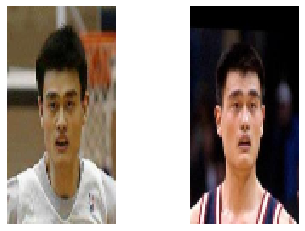

In [4]:
# Define the configuration of HoG feature extraction

# Resize the input image to a fixed resolution for feature extraction
IMG_HEIGHT = 128
IMG_WIDTH = 64

# Block size, Cell size, Stride size, Number of bins as defined in HoG.
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

# Step 1: Load images and resize images
test_image1 = cv2.imread('yao2.jpg')
test_image2 = cv2.imread('yao1.jpg')

test_image1 = cv2.resize(test_image1, (IMG_WIDTH, IMG_HEIGHT))
test_image2 = cv2.resize(test_image2, (IMG_WIDTH, IMG_HEIGHT))

# Step 2: Extract HoG features
hog = cv2.HOGDescriptor((IMG_WIDTH, IMG_HEIGHT), blockSize, blockStride, cellSize, nbins)
test_image1_hog = hog.compute(test_image1)
test_image2_hog = hog.compute(test_image2)

# Step 3: Normalize the HoG features and calculate their cosine similarity distance
test_image1_hog = test_image1_hog/np.linalg.norm(test_image1_hog)
test_image2_hog = test_image2_hog/np.linalg.norm(test_image2_hog)

sims = np.inner(np.transpose(test_image1_hog), np.transpose(test_image2_hog))
print('The similarity of two images is %.4f' % sims)

# Display the input images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()


$\color{red}{\text{Q1. Complete the code to build a HoG-based image similarity evaluation model.}}$

Tasks
- Choose two images based on your interests, such as your own face photo or downloaded photo
- Evaluate the similairty using the HoG feature extraction method
- Fine tune the method by changing configurations of the HoG model

In [0]:
# provide your code here
# Step 1: Load images and resize images

# Step 2: Extract HoG features

# Step 3: Normalize the HoG features and calculate their cosine similarity distance


# Explore LFW face dataset

The dataset consists of folders corresponding to each person. The folder name is the name of the person.

First, we map each class (identity) to an integer id, and build mappings as dictionaries.
- mappings from person name (folder name) and class id: `name_to_classid` and `classid_to_name`

Furthermore, in each folder, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries
- mappings from imagepath and image id: `path_to_imageid` and `imageid_to_path`
- mappings from class id to image id: `classid_to_imageid` and `imageid_to_classid`

Summary 
- name: person name, folder name
- classid: integer number to indicate the person name
- path: path to save the person images
- imageid: integer number to indicate the image file index

In [5]:
# Define the path for the downloaded images
PATH = "lfw-deepfunneled/"

# We only use subset of this dataset, say 500 folders
USE_SUBSET = True

dirs = sorted(os.listdir(PATH))
print("Total number of classes (persons) in the full dataset: ", len(dirs))
if USE_SUBSET:
    dirs = dirs[:500]
print("Total number of classes (persons) in workshop: ", len(dirs))

# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}

# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}


Total number of classes (persons) in the full dataset:  5749
Total number of classes (persons) in workshop:  500


# Prepare dataset to train a deep learning model for person verification

- Build paris of positive and negative training images
- Split dataset into train and test subsets for model training


In [0]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_imageid(classid, max_num=50):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
def build_neg_pairs_for_imageid(classid, classes, max_num=20):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, max_num+1)
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path,0)
        temp = cv2.resize(temp, (100, 100))        
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)



In [7]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes)

print('Prepare train pairs', len(train_Y), ', test pairs', len(test_Y))

# # Open all images
# all_imgs = open_all_images(imageid_to_path)
# print('Total images: ', all_imgs.shape)


Prepare train pairs 2354 , test pairs 298


# Exercise 2: Design and train a person verification model

Objectives
- Build a convolutional model. Warning: Large convolutions on high dimensional images can be very slow on CPUs.


Prepare dataset
- generate list of file names, train_pairs_file_list, test_pairs_file_list
- create a customized dataset class my_ImageList
- create dataset loader torch.utils.data.DataLoader
- load batch image data, assign to cuda
- pros: cuda memory saving
- cons: need to create customized dataset class

In [8]:
imageid_to_path_all_values = np.array(list(imageid_to_path.values()))

train_pairs_file_list = []
for i in range(train_Y.shape[0]):
    imgPath1 = imageid_to_path_all_values[X1_ids_train[i]]
    imgPath2 = imageid_to_path_all_values[X2_ids_train[i]]
    label = train_Y[i]
    train_pairs_file_list.append([imgPath1, imgPath2, label])
    
test_pairs_file_list = []
for i in range(test_Y.shape[0]):
    imgPath1 = imageid_to_path_all_values[X1_ids_test[i]]
    imgPath2 = imageid_to_path_all_values[X2_ids_test[i]]
    label = test_Y[i]
    test_pairs_file_list.append([imgPath1, imgPath2, label])
    
print(len(train_pairs_file_list))
print(len(test_pairs_file_list))
for i in range(10):
    [imgPath1, imgPath2, target] = train_pairs_file_list[i]
    print(i, imgPath1, imgPath2, target)


2354
298
0 lfw-deepfunneled/Aleksander_Kwasniewski/Aleksander_Kwasniewski_0002.jpg lfw-deepfunneled/Alberto_Gonzales/Alberto_Gonzales_0001.jpg 0
1 lfw-deepfunneled/Anastasia_Myskina/Anastasia_Myskina_0002.jpg lfw-deepfunneled/Anastasia_Myskina/Anastasia_Myskina_0003.jpg 1
2 lfw-deepfunneled/Andy_Roddick/Andy_Roddick_0011.jpg lfw-deepfunneled/Aiysha_Smith/Aiysha_Smith_0001.jpg 0
3 lfw-deepfunneled/Arye_Mekel/Arye_Mekel_0001.jpg lfw-deepfunneled/Arye_Mekel/Arye_Mekel_0002.jpg 1
4 lfw-deepfunneled/Andy_Roddick/Andy_Roddick_0005.jpg lfw-deepfunneled/Angela_Lansbury/Angela_Lansbury_0001.jpg 0
5 lfw-deepfunneled/Alvaro_Uribe/Alvaro_Uribe_0032.jpg lfw-deepfunneled/Anthony_Hopkins/Anthony_Hopkins_0001.jpg 0
6 lfw-deepfunneled/Adolfo_Rodriguez_Saa/Adolfo_Rodriguez_Saa_0001.jpg lfw-deepfunneled/Adolfo_Rodriguez_Saa/Adolfo_Rodriguez_Saa_0002.jpg 1
7 lfw-deepfunneled/Anne_Cavers/Anne_Cavers_0001.jpg lfw-deepfunneled/Adolfo_Aguilar_Zinser/Adolfo_Aguilar_Zinser_0001.jpg 0
8 lfw-deepfunneled/Ana_Guev

In [0]:
# # We need to convert label from int to string to save it in txt file
# #
# f = open('pt_data_train.txt', 'w')
# for file_name in train_pairs_file_list:
# #     print(file_name)
#     line = file_name[0] + ' ' + file_name[1] + ' ' + str(file_name[2]) + '\n'
#     f.write(line)
# f.close()

# f = open('pt_data_test.txt', 'w')
# for file_name in test_pairs_file_list:
#     line = file_name[0] + ' ' + file_name[1] + ' ' + str(file_name[2]) + '\n'
#     f.write(line)
# f.close()

# Exercise 3: Apply the person verification model to evaluate the similarity of two person images

Objective
- Given two person images, extract their features using the pre-trained siamese model, and calculate their cosine similarity (larger value indicates higher similarity)

In [0]:
# Reference: https://github.com/Jin-Linhao/Siamese_lfw_pytorch

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512)
            )
            

        self.fc = nn.Sequential(
            nn.Linear(131072, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024))


    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [0]:
def train_loader(path):
    img = Image.open(path)
    return img

def test_loader(path):
    img = Image.open(path)
    return img

def default_list_reader(fileList):
    imgList = []
    with open(fileList, 'r') as file:
        for line in file.readlines():
            imgshortList = []
            imgPath1, imgPath2, label = line.strip().split(' ')

            imgshortList.append(imgPath1)
            imgshortList.append(imgPath2)
            imgshortList.append(int(label))
            imgList.append(imgshortList)
    return imgList


class train_ImageList(torch.utils.data.Dataset):
    def __init__(self, fileList, transform=None, list_reader=default_list_reader, train_loader=train_loader):
        self.imgList   = list_reader(fileList)
        self.transform = transform
        self.train_loader = train_loader

    def __getitem__(self, index):
        final = []
        [imgPath1, imgPath2, target] = self.imgList[index]
        img1 = self.train_loader(imgPath1)
        img2 = self.train_loader(imgPath2)


        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img1, img2, torch.from_numpy(np.array([target],dtype=np.float32))

    def __len__(self):
        return len(self.imgList)


class test_ImageList(torch.utils.data.Dataset):
    def __init__(self, fileList, transform=None, list_reader=default_list_reader, test_loader=test_loader):
        self.imgList   = list_reader(fileList)
        self.transform = transform
        self.test_loader = test_loader

    def __getitem__(self, index):
        final = []
        [imgPath1, imgPath2, target] = self.imgList[index]
        img1 = self.test_loader(imgPath1)
        img2 = self.test_loader(imgPath2)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([target],dtype=np.float32))

    def __len__(self):
        return len(self.imgList)


class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=1):
        super(ContrastiveLoss, self).__init__()
        # margin = args.batch_size*3
        self.margin = margin


    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [0]:
def train(train_dataloader, model, criterion, optimizer, epoch):
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        img0, img1 , label = data
        img0 = img0.to(device)
        img1 = img1.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output1, output2 = model(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()

        if ((i%20) == 0):
            print("Epoch: %d, iter %d/%d, total loss: %.4f" % (epoch+1, i+1, len(train_dataloader), loss_contrastive.cpu().item()))
        running_loss += loss_contrastive.cpu().item()

    print("Epoch: %d, total loss: %.4f" % (epoch+1, loss_contrastive.cpu().item()))



In [0]:
batch_size = 64
learning_rate = 1e-3
num_epoch = 20

train_dataloader = torch.utils.data.DataLoader(
                    train_ImageList(fileList='pt_data_train.txt', 
                            transform=transforms.Compose([ 
                            transforms.Resize((128,128)),
                            transforms.ToTensor(), ])),
                    shuffle=True,
                    batch_size=batch_size)


In [14]:
model = SiameseNetwork()
model.to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

for epoch in range(num_epoch):

    model.train()
    train(train_dataloader, model, criterion, optimizer, epoch)

print('Training is finished.')

Epoch: 1, iter 1/37, total loss: 941.7296
Epoch: 1, iter 21/37, total loss: 600.0804
Epoch: 1, total loss: 309.4688
Epoch: 2, iter 1/37, total loss: 250.2659
Epoch: 2, iter 21/37, total loss: 108.9572
Epoch: 2, total loss: 52.1234
Epoch: 3, iter 1/37, total loss: 52.3183
Epoch: 3, iter 21/37, total loss: 20.9403
Epoch: 3, total loss: 13.2520
Epoch: 4, iter 1/37, total loss: 10.8172
Epoch: 4, iter 21/37, total loss: 4.2378
Epoch: 4, total loss: 2.5285
Epoch: 5, iter 1/37, total loss: 1.9334
Epoch: 5, iter 21/37, total loss: 1.1763
Epoch: 5, total loss: 0.5556
Epoch: 6, iter 1/37, total loss: 0.5163
Epoch: 6, iter 21/37, total loss: 0.3665
Epoch: 6, total loss: 0.2767
Epoch: 7, iter 1/37, total loss: 0.2865
Epoch: 7, iter 21/37, total loss: 0.2708
Epoch: 7, total loss: 0.2657
Epoch: 8, iter 1/37, total loss: 0.2799
Epoch: 8, iter 21/37, total loss: 0.2652
Epoch: 8, total loss: 0.2678
Epoch: 9, iter 1/37, total loss: 0.2698
Epoch: 9, iter 21/37, total loss: 0.2625
Epoch: 9, total loss: 0.

In [0]:
def validate(test_dataloader, model, criterion):
    cnt = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dataloader):
            img0, img1 , label = data

            img0 = img0.to(device)
            img1 = img1.to(device)
            label = label.to(device)

            output1, output2 = model(img0, img1)
            euclidean_distance = F.pairwise_distance(output1, output2)

            dis = 0
            total_dis = 0
            for j in range(0, label.size(0)):
                total_dis = euclidean_distance[j].item() + total_dis
                dis = total_dis/label.size(0)

            for k in range(0, label.size(0)):
                predicted = (euclidean_distance[j].item() < dis)
                label_data = label.data
                cnt += torch.sum(predicted == label_data[j])
                total += 1

    return cnt, total

In [16]:
valid_dataloader = torch.utils.data.DataLoader(
                    test_ImageList(fileList='pt_data_test.txt', 
                            transform=transforms.Compose([ 
                            transforms.Resize((128,128)),
                            transforms.ToTensor(), ])),
                    shuffle=False,
                    batch_size=batch_size)

correct, total = validate(valid_dataloader, model, criterion)
print("correct matches: %d, total matches: %d " % (correct, total))
print("total accuracy: %.4f" % (float(correct)/total))


correct matches: 192, total matches: 298 
total accuracy: 0.6443


Label: 1, Distance: 0.5082


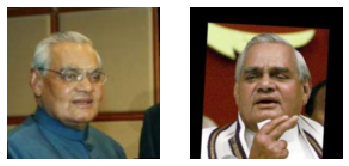

Label: 0, Distance: 0.6321


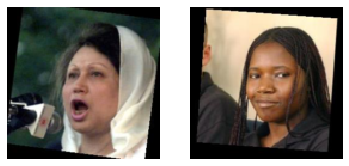

Label: 0, Distance: 0.5503


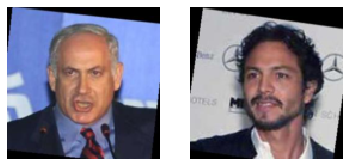

Label: 0, Distance: 0.5103


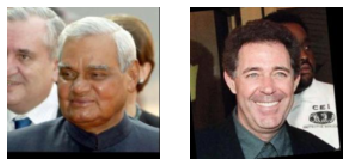

Label: 0, Distance: 0.6454


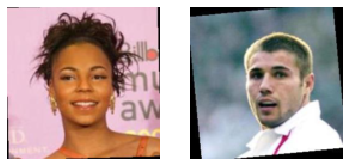

Label: 1, Distance: 0.4600


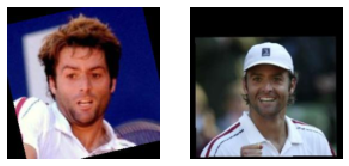

Label: 0, Distance: 0.3914


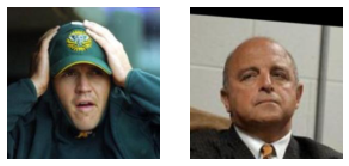

Label: 1, Distance: 0.5330


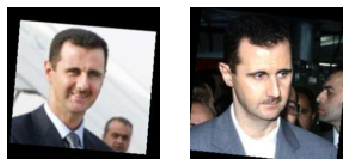

Label: 1, Distance: 0.3842


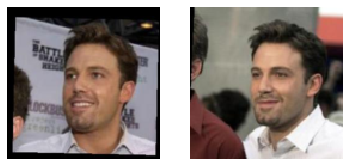

Label: 1, Distance: 0.6369


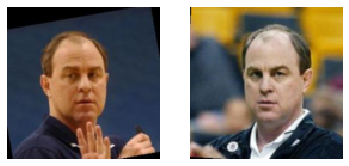

Label: 1, Distance: 0.3488


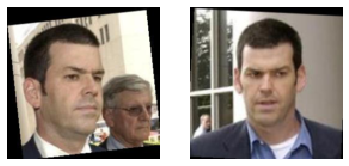

Label: 0, Distance: 0.4284


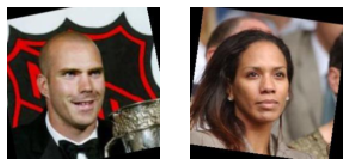

In [17]:
test_dataloader = torch.utils.data.DataLoader(
                    test_ImageList(fileList='pt_data_test.txt', 
                            transform=transforms.Compose([ 
                            transforms.Resize((128,128)),
                            transforms.ToTensor(), ])),
                    shuffle=True,
                    batch_size=1)

model.eval()
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        img0, img1 , label = data

        img0 = img0.to(device)
        img1 = img1.to(device)
        label = label.to(device)

        output1, output2 = model(img0, img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        print('Label: %d, Distance: %.4f' % (label.item(), euclidean_distance.item()))

        result0 = np.array(img0.squeeze().cpu()).transpose([1, 2, 0])
        result1 = np.array(img1.squeeze().cpu()).transpose([1, 2, 0])
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(result0)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(result1)
        plt.axis('off')
        plt.show()
        
        if (idx >10):
            break

torch.Size([1, 1024]) torch.Size([1, 1024])
The similarity of two images is 0.3872


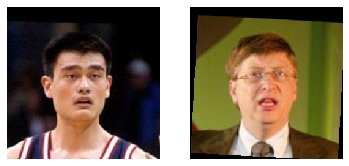

In [18]:
# Step 1: Load images and resize images
test_image1 = Image.open('yao1.jpg')
test_image2 = Image.open('yao2.jpg')
test_image2 = Image.open('bill1.jpg')

transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

test_image1_tensor = transform(test_image1).unsqueeze(0).to(device)
test_image2_tensor = transform(test_image2).unsqueeze(0).to(device)

# Step 2: Extract features using the pre-trained siamese model
model.eval()
with torch.no_grad():
    output1, output2 = model(test_image1_tensor, test_image2_tensor)

print(output1.shape, output2.shape)
dist = F.pairwise_distance(output1, output2)
print('The similarity of two images is %.4f' % dist.item())

# Plot the two given images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(np.array(test_image1))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.array(test_image2))
plt.axis('off')
plt.show()

$\color{red}{\text{Q2. Complete the code to build an image similarity evaluation model.}}$

Tasks
- Choose two images based on your interests, such as your own photo or downloaded photo
- Evaluate the similairty using the pre-trained siamese model

In [0]:
# provide your code here

# Step 1: Load images and resize images

# Step 2: Extract features using the pre-trained siamese model

# Step 3: Normalize features and calculate their similarity distance


$\color{red}{\text{Q3. Propose how to further boost the accuracy performance of the person verification model used in this workshop.}}$

For example: Apply the face detection on the input image, then use detected face as training data, instead of using the whole image as training data.

In [0]:
# Provide your answers here
#
#
#
#
#
#

**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!